In [1]:

import numpy as np
import numpy.ma as ma
from astropy.table import Table
import matplotlib.pyplot as plt
from disk_mass import calc_mass_curve, fit_mass_curve
from combin_fit_functions import combination_fit
from DRP_rotation_curve import extract_data, extract_Pipe3d_data
from rotation_fitfunctions import find_phi, find_axis_ratio, chi2
from disk_mass_plotting_functions import plot_fitted_disk_rot_curve
import RC_plotting_functions as RC
%matplotlib inline

In [31]:
import importlib
import disk_mass
import rotation_fitfunctions
importlib.reload(RC)
from combin_fit_functions import combination_fit

In [82]:
SigD = 651.0289797724238
Rd = 0.903804192022047
rho_b =  120050641.10390615
Rb = 2.73444270675828

params = [-1.634517103582505, 7.363831777290586, 0.506337302748544, 0.6993130761460795, 36.5964126142139, 37.67240962101176, 14.097480189066221]

from rotation_fitfunctions import parameterfit_iso
testfit = parameterfit_iso(params, rho_b, Rb, SigD, Rd, scale, shape, maps['vmasked'], maps['ivarmasked'], vmap_mask)


[[-7, 2], [1, 1000], [0, 1.029936078346843], [0.4375136883469301, 0.9611124639452289], [31.596412614213897, 41.5964126142139], [32.67240962101176, 42.67240962101176], [-100, 100]]
[-1.634517103582505, 7.363831777290586, 0.506337302748544, 0.6993130761460795, 36.5964126142139, 37.67240962101176, 0]
---------------------------------------------------
Status: 0 Values [-6.98403108e+00  9.99999955e+02  3.47526107e-05  4.37569694e-01
  4.15963530e+01  3.26724692e+01 -1.20825491e+01]


In [2]:
gal_ID = '8997-9102'
H_0 = 100  # Hubble's Constant in units of h km/s/Mpc
c = 299792.458  # Speed of light in units of km/s

In [3]:
MANGA_FOLDER = '/scratch/kdougla7/data/SDSS/dr17/manga/spectro/'
MASS_MAP_FOLDER = MANGA_FOLDER + 'pipe3d/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v3_1_1/3.1.0/HYB10-MILESHC-MASTARSSP/'
DRP_FILENAME = MANGA_FOLDER + 'redux/v3_1_1/' + 'drpall-v3_1_1.fits'


In [4]:
DRP_table = Table.read( DRP_FILENAME, format='fits')


DRP_index = {}

for i in range(len(DRP_table)):
    galaxy_ID = DRP_table['plateifu'][i]

    DRP_index[galaxy_ID] = i


In [5]:
maps = extract_data(VEL_MAP_FOLDER,gal_ID,['Ha_vel', 'r_band', 'Ha_flux', 'Ha_sigma'])
sMass_density, sMass_density_err = extract_Pipe3d_data(MASS_MAP_FOLDER, gal_ID)
i_DRP = DRP_index[gal_ID]
axis_ratio = [DRP_table['nsa_sersic_ba'][i_DRP]]
incl = np.arccos(np.sqrt((axis_ratio[0]**2 - 0.2**2)/(1-0.2**2))) 
phi = DRP_table['nsa_elpetro_phi'][i_DRP]
print(phi)
z = DRP_table['nsa_z'][i_DRP]
SN_map = maps['Ha_flux'] * np.sqrt(maps['Ha_flux_ivar'])
vmap_mask = maps['Ha_vel_mask'] + (SN_map < 5)
sM_mask = maps['Ha_vel_mask']
maps['vmasked'] = ma.array(maps['Ha_vel'], mask=vmap_mask)
maps['ivarmasked'] = ma.array(maps['Ha_vel_ivar'], mask=vmap_mask)

shape = maps['vmasked'].shape
scale = (0.5 * z * c / H_0) * 1000 / 206265  # kpc
center = np.unravel_index(ma.argmax(maps['r_band']), shape)
x0 = [center[0]]
y0 = [center[1]]
phi = [find_phi(center, phi, maps['vmasked'])]
#param = [incl, phi, x_center, y_center]
print(phi)

129.725
9.120986
(31, 31)
2.264128372149644
[5.405721025739437]


In [6]:
rho_h = [-1.5]
Rh = [10]
vsys = [0]


In [7]:
for i in range(50):
    params = rho_h[-1], Rh[-1], axis_ratio[-1], phi[0], x0[-1], y0[-1],  vsys[-1]
    fit, mass_table, mass_param= combination_fit(sMass_density, sMass_density_err, maps['r_band'], maps['vmasked'], maps['ivarmasked'], vmap_mask, \
                sM_mask, params, z, gal_ID, "NFW")
    print("chi2",chi2(maps['vmasked'], maps['ivarmasked'], vmap_mask,shape,scale,fit,"NFW"))
    x0.append(fit[8])
    y0.append(fit[9])
    axis_ratio.append(find_axis_ratio(fit[6]))
    phi.append(fit[7])
    rho_h.append(fit[4])
    Rh.append(fit[5])
    vsys.append(fit[10])
    
    if np.abs(x0[-2]-x0[-1])<1 and np.abs(y0[-2]-y0[-1])<1 and np.abs(phi[-2]-phi[-1])<0.00017 and \
        np.abs(axis_ratio[-2]-axis_ratio[-1])<0.001 and np.abs(vsys[-2]-vsys[-1])<0.1:
        print("Converged")
        break
    
#RC.plot_rot_curve(maps['vmasked'],maps['ivarmasked'], fit,scale,gal_ID,'NFW')

Fitting disk
finding mass curve
{'Sigma_disk': 506.75751349522073, 'Sigma_disk_err': 34.534995305459844, 'R_disk': 1.8483025416748942, 'R_disk_err': 0.051384983893136504, 'rho_bulge': 9.697038374564945, 'rho_bulge_err': 0.17791314871026218, 'R_bulge': 0.3548407981019254, 'R_bulge_err': 0.005103344027218095, 'chi2_disk': 337861.91511146486}
Fitting velocity map
---------------------------------------------------
Status: 0 Values [-1.3227983  13.5735501   0.35680412  5.54855441 31.31072911 30.98076588
 10.02991826]
chi2 (13048.208766678235, 7.076035122927459)
Fitting disk
finding mass curve
{'Sigma_disk': 513.4810378599336, 'Sigma_disk_err': 40.604105483351574, 'R_disk': 1.8181364035521335, 'R_disk_err': 0.059082334788161134, 'rho_bulge': 9.24318222564483, 'rho_bulge_err': 0.15956670846623883, 'R_bulge': 0.3654489338516588, 'R_bulge_err': 0.005432040320647455, 'chi2_disk': 318812.03327094036}
Fitting velocity map
---------------------------------------------------
Status: 0 Values [-1.32

In [60]:
iso_fit = fit

[9.24318222564483, 0.3654489338516588, 513.4810378599336, 1.8181364035521335, -1.3264585507411681, 13.542347808208108, 0.3566991026804219, 5.54848187920381, 31.311950451873564, 30.984122243827564, 10.059958410060116]
286.9566699969658


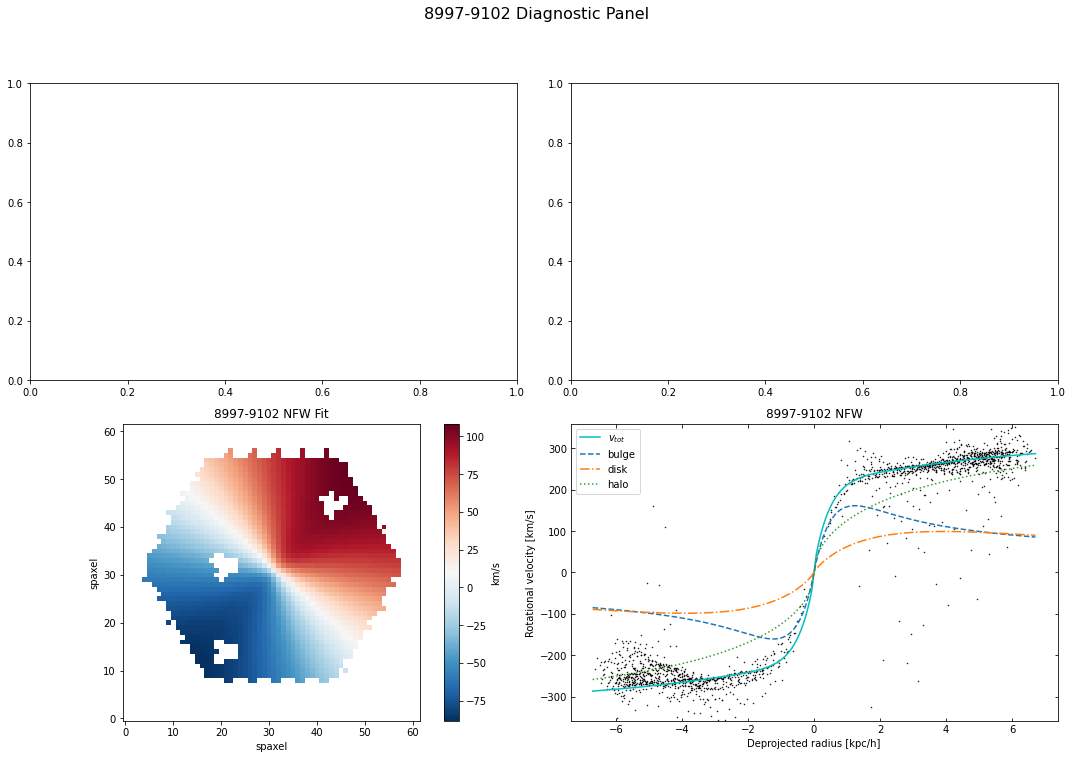

In [32]:
RC.plot_totfit_panel (gal_ID, shape, scale, fit, "NFW", vmap_mask, maps['vmasked'], maps['ivarmasked'], mass_table, mass_param)

In [64]:
burkert_fit = fit

In [68]:
NFW_fit = fit


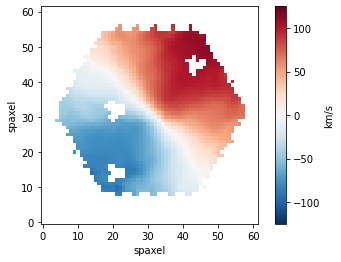

In [72]:
plt.imshow(maps['vmasked'], 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-125, 
           vmax=125)

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar()
cbar.set_label('km/s')
plt.savefig("8997-9102_data")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[9.25411432052376, 0.36517936808901474, 494.2811967385933, 1.8496136171225965, -1.097544821355514, 8.295205106012595, 0.46829212570149054, 5.549729751013304, 31.366819894965143, 30.895829910265256, 9.86742845609226]
Iso: [9.25411432052376, 0.36517936808901474, 494.2811967385933, 1.8496136171225965, -1.097544821355514, 8.295205106012595, 0.46829212570149054, 5.549729751013304, 31.366819894965143, 30.895829910265256, 9.86742845609226]
[9.25411432052376, 0.36517936808901474, 494.2811967385933, 1.8496136171225965, -1.097544821355514, 8.295205106012595, 0.46829212570149054, 5.549729751013304, 31.366819894965143, 30.895829910265256, 9.86742845609226]
254.70696119369015
NFW [9.2431821362807, 0.3654489405080505, 513.480980130021, 1.8181364865652418, -1.3264586117665302, 13.542349767466444, 0.3566991098625241, 5.548481883600306, 31.311951019269966, 30.984121995723495, 10.05995956812505]
[9.2431821362807, 0.3654489405080505, 513.480980130021, 1.8181364865652418, -1.3264586117665302, 13.542349767

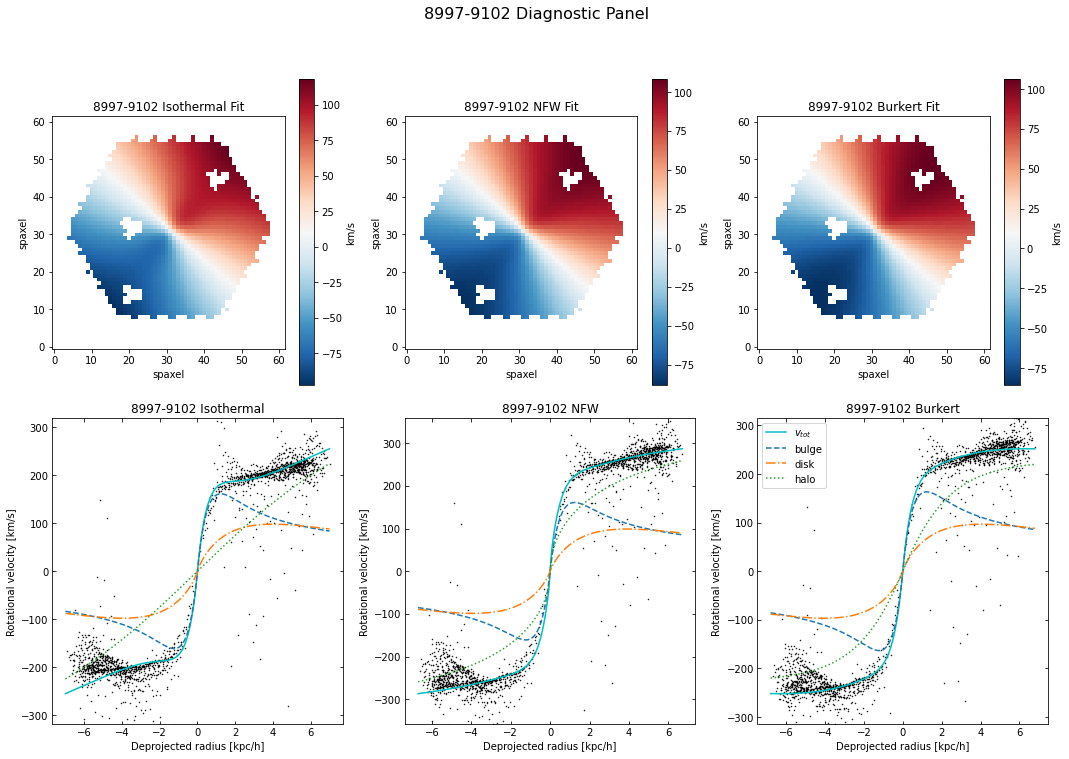

In [69]:
RC.plot_diagnostic_panel(gal_ID,shape,scale,iso_fit,NFW_fit,burkert_fit,vmap_mask,maps['vmasked'], maps['ivarmasked'])

[9.254439263261874, 0.36513456814689665, 494.7607311800626, 1.849033597887051, -1.096140072152332, 8.26422523632873, 0.46795502005207396, 5.549649905357762, 31.364177312378267, 30.89966116223119, 9.881482149476728]
254.82769667097466
[9.254439263261874, 0.36513456814689665, 494.7607311800626, 1.849033597887051, -1.096140072152332, 8.26422523632873, 0.46795502005207396, 5.549649905357762, 31.364177312378267, 30.89966116223119, 9.881482149476728]


TypeError: must be real number, not tuple

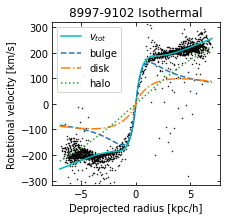

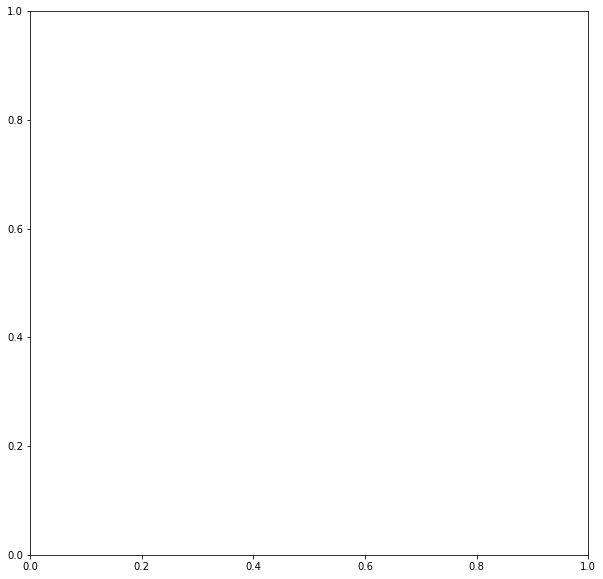

In [20]:
#fit = [0.18099674504059157, 2.36567224666019, 650.5768214537034, 1.0586977469027725, -3.5011803336671505, 252.61582026994608, 1.0632743240765112, 0.697008255889674, 36.55894334110698, 37.70123071916189, 14.702324825483247]
RC.plot_rot_curve(maps['vmasked'],maps['ivarmasked'], fit,scale,gal_ID,'Isothermal')
RC.Plotting_Isothermal(gal_ID,scale,shape,[9.254439263261874, 0.36513456814689665, 494.7607311800626, 1.849033597887051, -1.096140072152332, 8.26422523632873, 0.46795502005207396, 5.549649905357762, 31.364177312378267, 30.89966116223119, 9.881482149476728],vmap_mask)

In [19]:
from galaxy_component_functions_cython import disk_vel
disk_vel(1.5674325693431719*1000,650.5768214537034, 1.0586977469027725*1000)

6617725573.807876


81.34940426215718

In [25]:
print(len(x0))

51


In [27]:
x0diff = []
y0diff = []
phidiff = []
axis_ratiodiff = []
rho_hdiff = []
Rhdiff = []
vsysdiff = []

for i in range(len(x0)-1):
    print(i)
    x0diff.append(np.abs(x0[i+1]-x0[i]))
    y0diff.append(np.abs(y0[i+1]-y0[i]))
    phidiff.append(np.abs(phi[i+1]-phi[i]))
    axis_ratiodiff.append(np.abs( axis_ratio[i+1]-axis_ratio[i]))
    rho_hdiff.append(np.abs(rho_h[i+1]-rho_h[i]))
    Rhdiff.append(np.abs(Rh[i+1]-Rh[i]))
    vsysdiff.append(np.abs(vsys[i+1]-vsys[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


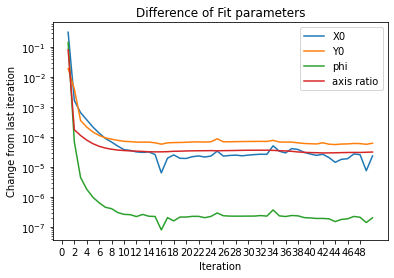

In [30]:
r = range(1,len(x0))
plt.plot(r,x0diff)
plt.plot(r,y0diff)
plt.plot(r,phidiff)
plt.plot(r,axis_ratiodiff)
#plt.plot(r,rho_hdiff)
#plt.plot(r,Rhdiff)
#plt.plot(r,vsysdiff)
plt.legend(['X0','Y0','phi','axis ratio', 'rhoh', 'Rh','vsys'])
plt.xticks(np.arange(0, 50, step=2))
plt.xlabel("Iteration")
plt.ylabel("Change from last iteration")
plt.yscale('log')
plt.title('Difference of Fit parameters')
#plt.xlim([1,50])
#plt.ylim([0,5])
plt.savefig('isodifferenceoffitparameters')

ValueError: x and y must have same first dimension, but have shapes (20,) and (50,)

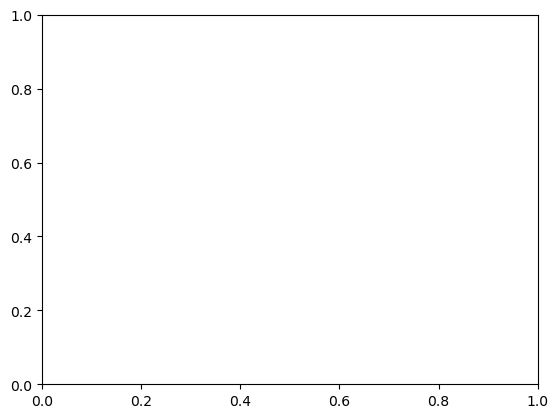

In [138]:
r = range(2,22)
plt.plot(r,x0diff)
plt.plot(r,y0diff)
plt.plot(r,phidiff)
plt.plot(r,axis_ratiodiff)
plt.plot(r,rho_hdiff)
plt.plot(r,Rhdiff)
plt.legend(['X0','Y0','phi','axis ratio', 'rhoh', 'Rh'])
plt.xticks(np.arange(0, 20, step=2))
plt.xlabel("Iteration")
plt.ylabel("Change from last iteration")
plt.xlim([15,20])
plt.ylim([0,0.001])


(0.0, 1e-12)

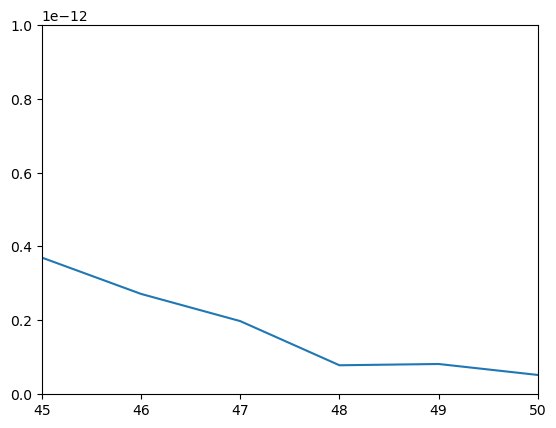

In [166]:
plt.plot(r,phidiff)
plt.xlim([45,50])
plt.ylim([0,0.000000000001])

In [167]:
print(Rhdiff)

[6.12352125883303, 3.1814734875597495, 0.12331187079152972, 0.0818750958579022, 0.04761873305826114, 0.032459732362531746, 0.020614116493641532, 0.01395633381737671, 0.009016276007210777, 0.005998569938415521, 0.00398440172970016, 0.002648339170407077, 0.0017592933496430874, 0.0011682505982770763, 0.0007755765726837893, 0.000514802772177525, 0.0003416716498803041, 0.00022674882908724214, 0.00015047347551355728, 9.985291982594902e-05, 6.626013008670384e-05, 4.396808295759058e-05, 2.9175530549707673e-05, 1.9359638590010775e-05, 1.2846173187419652e-05, 8.524112832475339e-06, 5.656190601222022e-06, 3.753174085296962e-06, 2.4904067252862205e-06, 1.6525067501049762e-06, 1.0965285994757323e-06, 7.276083229257324e-07, 4.827904529491889e-07, 3.2036764974208154e-07, 2.1256594173735266e-07, 1.4104768553124813e-07, 9.359817543241888e-08, 6.211110648024487e-08, 4.121088981179355e-08, 2.7340678165899135e-08, 1.814841699143699e-08, 1.2035449969971523e-08, 7.992803752188138e-09, 5.30229904427415e-09, 

In [168]:
print(phidiff)

[0.05510458072566127, 0.0004821988440649738, 2.4523636018791706e-05, 1.8613099993514126e-05, 1.0881835209475277e-05, 4.7956947544225415e-06, 3.22047725953567e-06, 1.4207003218302816e-06, 1.2172567744883622e-06, 7.496336301704432e-07, 4.5369785250937156e-07, 2.981043001337724e-07, 1.9644639892568705e-07, 1.2979132235635404e-07, 8.588147681898306e-08, 5.688015081162234e-08, 3.76958738668165e-08, 2.4992394487277636e-08, 1.6574554062565028e-08, 1.0994022026089567e-08, 7.293323500690008e-09, 4.838677458707252e-09, 3.2103762981350314e-09, 2.130093990082571e-09, 1.4133429981910695e-09, 9.377830734180748e-10, 6.22277784856351e-10, 4.129061537128109e-10, 2.739447557686958e-10, 1.8179990846078908e-10, 1.2065060062127486e-10, 8.006229013091115e-11, 5.3090420948365136e-11, 3.524469605054037e-11, 2.3363644352514257e-11, 1.5523915486426176e-11, 1.0285883256244688e-11, 6.86084522527608e-12, 4.5318193642174265e-12, 2.9889424268958464e-12, 2.0021762026090073e-12, 1.3158363287857355e-12, 8.9572793626757

In [169]:
difference = Table()

In [171]:
difference['x0']=x0diff
difference['y0']=y0diff
difference['phi']=phidiff
difference['axis ratio']=axis_ratiodiff
difference['Halo density']=rho_hdiff
difference['Halo scale radius']=Rhdiff

In [177]:
difference.write('iterationsdiff', format='csv', overwrite = True)

In [175]:
Table.write.list_formats()

           Format           Read Write Auto-identify Deprecated
--------------------------- ---- ----- ------------- ----------
                      ascii  Yes   Yes            No           
               ascii.aastex  Yes   Yes            No           
                ascii.basic  Yes   Yes            No           
     ascii.commented_header  Yes   Yes            No           
                  ascii.csv  Yes   Yes           Yes           
                 ascii.ecsv  Yes   Yes           Yes           
           ascii.fast_basic  Yes   Yes            No           
ascii.fast_commented_header  Yes   Yes            No           
             ascii.fast_csv  Yes   Yes            No           
       ascii.fast_no_header  Yes   Yes            No           
             ascii.fast_rdb  Yes   Yes            No           
             ascii.fast_tab  Yes   Yes            No           
          ascii.fixed_width  Yes   Yes            No           
ascii.fixed_width_no_header  Yes   Yes  

In [11]:
test = [0]